In [1]:
# Python modules.
import datetime as dt
import os
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../data")


# Other modules.
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
)

# Library.
from src.utils import (
    make_a_sound,
    prepare_submission,
    submit_file,
    get_submission_scores,
)
from src.eda import (
    distplot,
    correlation_heatmap,
    compare_predictions_and_real_values,
    vizualize_feature_importance,
    vizualise_residual,
)
from src.preprocessing import (
    compute_statistical_df_focusing_on_output_and_specific_column,
    create_new_columns_based_on_categorical_columns,
    fill_df_navalues,
    scale_and_encoder_features,
    encode_categories_using_encoders_and_scalers,
    split_X_y_in_train_test_sets,
    create_polynomial_features,
    get_dummies,
    generate_polynomial_column_using_polynomial_feature_encoder,
)

In [2]:
# Loading data
df_train = (
    pd.concat([
        pd.read_csv("data/train.csv"),
        pd.read_csv("data/training_extra.csv"),
    ])
)
df_test = pd.read_csv("data/test.csv")

In [3]:
# Optimize inputs cache memory.
## Train
df_train["id"] = df_train["id"].astype("int32")
df_train["Compartments"] = df_train["Compartments"].astype("int32")
df_train["Weight Capacity (kg)"] = df_train["Weight Capacity (kg)"].astype("float32")
df_train["Price"] = df_train["Price"].astype("float32")
## Test
df_test["id"] = df_test["id"].astype("int32")
df_test["Compartments"] = df_test["Compartments"].astype("int32")
df_test["Weight Capacity (kg)"] = df_test["Weight Capacity (kg)"].astype("float32")

### EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int32  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          int32  
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float32
 10  Price                 float32
dtypes: float32(2), int32(2), object(7)
memory usage: 304.7+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int32  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  int32  
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float32
dtypes: float32(1), int32(2), object(7)
memory usage: 13.0+ MB


<Figure size 1900x1000 with 0 Axes>

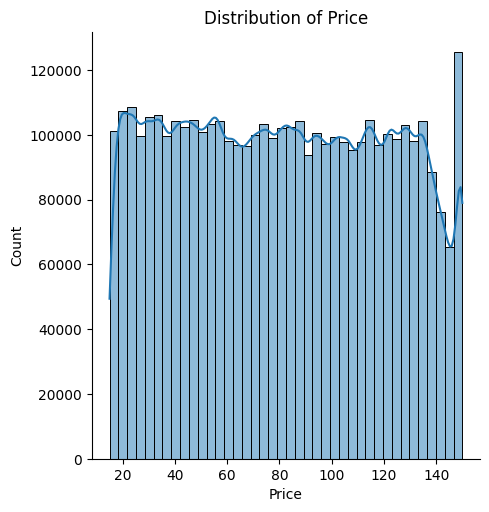

In [6]:
distplot(df=df_train, variable_name="Price")


<Figure size 1900x1000 with 0 Axes>

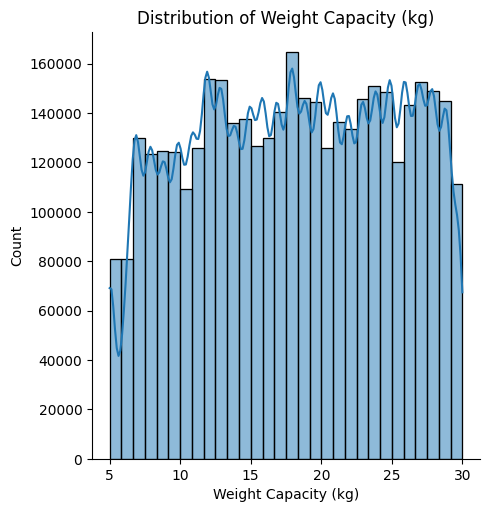

In [7]:
distplot(df=df_train, variable_name="Weight Capacity (kg)", bins=30)

## Setting reference

In [8]:
# Reference price - Settign ref score.
ref_price = df_train.Price.mean()
print(f"Mean price: {ref_price:.3f}.")
ref_score = np.sqrt(
    mean_squared_error(
        y_true=df_train.loc[:, "Price"],
        y_pred=np.ones(len(df_train)) * ref_price,
        )
    )
print(f"ref RMSE: {ref_score:.4f}")

Mean price: 81.362.
ref RMSE: 38.9387


## Preprocessing

In [10]:
categorical_column_names = list(df_train.columns[1:-2])
print(f"There are {len(categorical_column_names)} categorical columns.")
numerical_column_names = ["Weight Capacity (kg)"]
print(f"There are {len(numerical_column_names)} numerical columns.")

There are 8 categorical columns.
There are 1 numerical columns.


In [11]:
# Merging both before preprocessing the data.
df_tot = pd.concat([df_train, df_test])

In [12]:
# Preprocessing
df_tot_filled = fill_df_navalues(df=df_tot)
df_tot_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int32  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          int32  
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float32
 10  Price                 float32
dtypes: float32(2), int32(2), object(7)
memory usage: 320.0+ MB


## Creating new features

In [19]:
def find_weight_group(x):
    if x <= 7:
        return "Low Low"
    elif (x > 7) & (x <= 15):
        return "Low"
    elif (x > 15) & (x <= 22):
        return "Low Medium"
    elif (x > 22) & (x <= 30):
        return "Medium"
    elif (x > 30) & (x <= 37):
        return "Medium"
    else:
        return "High"


def find_compartment_group(x):
    if x <= 3.0:
        return "Low"
    elif (x > 3.0) & (x <= 5.0):
        return "Medium"
    elif (x > 5.0) & (x <= 7.0):
        return "Medium Plus"
    elif x > 7.0:
        return "High"


def find_style(x):
    if x in ["Under Armour", "Nike"]:
        return "Street Wear"
    elif x == "Jansport":
        return "Casual"
    elif x in ["Adidas", "Puma"]:
        return "Fancy Street Wear"


def find_material_price(x):
    if x in ["Leather"]:
        return "Expensive"
    elif x in ["Canvas", "Nylon"]:
        return "Medium"
    elif x in ["Polyester"]:
        return "Cheap"


def create_new_features(input_df: pd.DataFrame) -> pd.DataFrame:
    """Create variables using deduction and previous variables.
    Creating categories basically.

    :param input_df:
    :return pd.DataFrame:
    """
    output_df = input_df.copy()
    output_df["Weight Group"] = output_df["Weight Capacity (kg)"].apply(
        lambda x: find_weight_group(x)
    )
    output_df["Compartments"] = output_df.Compartments.astype("category")
    output_df["Compartement Group"] = output_df["Compartments"].apply(
        lambda x: find_compartment_group(x)
    )
    output_df["Brand Style"] = output_df["Brand"].apply(lambda x: find_style(x))
    output_df["Material Category"] = output_df["Material"].apply(lambda x: find_material_price(x))
    output_df["Weight Capacity (kg) log1"] = np.log1p(output_df["Weight Capacity (kg)"])
    output_df["Weight Capacity (kg) log10"] = np.log10(output_df["Weight Capacity (kg)"])
    output_df["Weight Capacity (kg) exp"] = np.expm1(output_df["Weight Capacity (kg)"])
    output_df["new_cat1"] = output_df[["Weight Group", "Compartement Group"]].sum(axis=1)
    # output_df["new_cat2"] = output_df[["Weight Group", "Brand Style"]].sum(axis=1)
    # output_df["new_cat3"] = output_df[["Weight Group", "Material Category"]].sum(axis=1)
    # output_df["new_cat4"] = output_df[["Weight Group", "Style"]].sum(axis=1)
    # output_df["new_cat5"] = output_df[["Weight Group", "Color"]].sum(axis=1)
    return output_df


df_tot_with_new_vars = create_new_features(input_df=df_tot)
df_tot_with_new_vars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   id                          int32   
 1   Brand                       object  
 2   Material                    object  
 3   Size                        object  
 4   Compartments                category
 5   Laptop Compartment          object  
 6   Waterproof                  object  
 7   Style                       object  
 8   Color                       object  
 9   Weight Capacity (kg)        float32 
 10  Price                       float32 
 11  Weight Group                object  
 12  Compartement Group          object  
 13  Brand Style                 object  
 14  Material Category           object  
 15  Weight Capacity (kg) log1   float32 
 16  Weight Capacity (kg) log10  float32 
 17  Weight Capacity (kg) exp    float32 
 18  new_cat1                    object  
dtypes: cat

In [20]:
df_tot_with_new_vars

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Weight Group,Compartement Group,Brand Style,Material Category,Weight Capacity (kg) log1,Weight Capacity (kg) log10,Weight Capacity (kg) exp,new_cat1
0,0,Jansport,Leather,Medium,7,Yes,No,Tote,Black,11.611723,112.158752,Low,Medium Plus,Casual,Expensive,2.534627,1.064897,1.103833e+05,LowMedium Plus
1,1,Jansport,Canvas,Small,10,Yes,Yes,Messenger,Green,27.078537,68.880562,Medium,High,Casual,Medium,3.335006,1.432625,5.755183e+11,MediumHigh
2,2,Under Armour,Leather,Small,2,Yes,No,Messenger,Red,16.643761,39.173199,Low Medium,Low,Street Wear,Expensive,2.870382,1.221251,1.691583e+07,Low MediumLow
3,3,Nike,Nylon,Small,8,Yes,No,Messenger,Green,12.937221,80.607933,Low,High,Street Wear,Medium,2.634563,1.111841,4.154918e+05,LowHigh
4,4,Adidas,Canvas,Medium,1,Yes,Yes,Messenger,Green,17.749338,86.023117,Low Medium,Low,Fancy Street Wear,Medium,2.931159,1.249182,5.110220e+07,Low MediumLow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,Adidas,Canvas,Large,2,Yes,No,Messenger,Red,7.383498,NaN,Low,Low,Fancy Street Wear,Medium,2.126265,0.868262,1.608209e+03,LowLow
199996,499996,Nike,Polyester,Small,9,No,Yes,Messenger,Pink,6.058394,NaN,Low Low,High,Street Wear,Cheap,1.954218,0.782358,4.266882e+02,Low LowHigh
199997,499997,Jansport,Nylon,Small,9,No,Yes,Tote,Green,26.890163,NaN,Medium,High,Casual,Medium,3.328274,1.429593,4.767049e+11,MediumHigh
199998,499998,Puma,Nylon,Large,10,Yes,No,Tote,Gray,25.769154,NaN,Medium,High,Fancy Street Wear,Medium,3.287250,1.411100,1.553822e+11,MediumHigh


In [21]:
# Scaling
df_tot_with_new_vars_scaled, scalers_and_encoders = scale_and_encoder_features(
    df=df_tot_with_new_vars,
    skip_column_names=["Price"],
)
df_tot_with_new_vars_scaled.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   id                          int32   
 1   Brand                       category
 2   Material                    category
 3   Size                        category
 4   Compartments                category
 5   Laptop Compartment          category
 6   Waterproof                  category
 7   Style                       category
 8   Color                       category
 9   Weight Capacity (kg)        float32 
 10  Price                       float32 
 11  Weight Group                category
 12  Compartement Group          category
 13  Brand Style                 category
 14  Material Category           category
 15  Weight Capacity (kg) log1   float32 
 16  Weight Capacity (kg) log10  float32 
 17  Weight Capacity (kg) exp    float32 
 18  new_cat1                    category
dtypes: cat

## Signal & noise

In [22]:
categorical_column_names = categorical_column_names + [
    "Weight Group",
    "Compartement Group",
    "Brand Style",
    "Material Category",
    "new_cat1",
]

In [23]:
df_tot_with_new_vars2_scaled = create_new_columns_based_on_categorical_columns(
    df=df_tot_with_new_vars_scaled,
    categorical_columns=categorical_column_names,
    output_col_name="Weight Capacity (kg)",
)
df_tot_with_new_vars2_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 32 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   id                          int32   
 1   Brand                       category
 2   Material                    category
 3   Size                        category
 4   Compartments                category
 5   Laptop Compartment          category
 6   Waterproof                  category
 7   Style                       category
 8   Color                       category
 9   Weight Capacity (kg)        float32 
 10  Price                       float32 
 11  Weight Group                category
 12  Compartement Group          category
 13  Brand Style                 category
 14  Material Category           category
 15  Weight Capacity (kg) log1   float32 
 16  Weight Capacity (kg) log10  float32 
 17  Weight Capacity (kg) exp    float32 
 18  new_cat1                    category
 19  brand_

## Dummies

In [24]:
df_tot_dummy = get_dummies(df=df_tot_with_new_vars2_scaled)
df_tot_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 98 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id                          int32  
 1   Weight Capacity (kg)        float32
 2   Price                       float32
 3   Weight Capacity (kg) log1   float32
 4   Weight Capacity (kg) log10  float32
 5   Weight Capacity (kg) exp    float32
 6   brand_wc                    float32
 7   material_wc                 float32
 8   size_wc                     float32
 9   compartments_wc             float32
 10  laptopcompartment_wc        float32
 11  waterproof_wc               float32
 12  style_wc                    float32
 13  color_wc                    float32
 14  weightgroup_wc              float32
 15  compartementgroup_wc        float32
 16  brandstyle_wc               float32
 17  materialcategory_wc         float32
 18  new_cat1_wc                 float32
 19  Brand_0                    

### Correlation matrix.

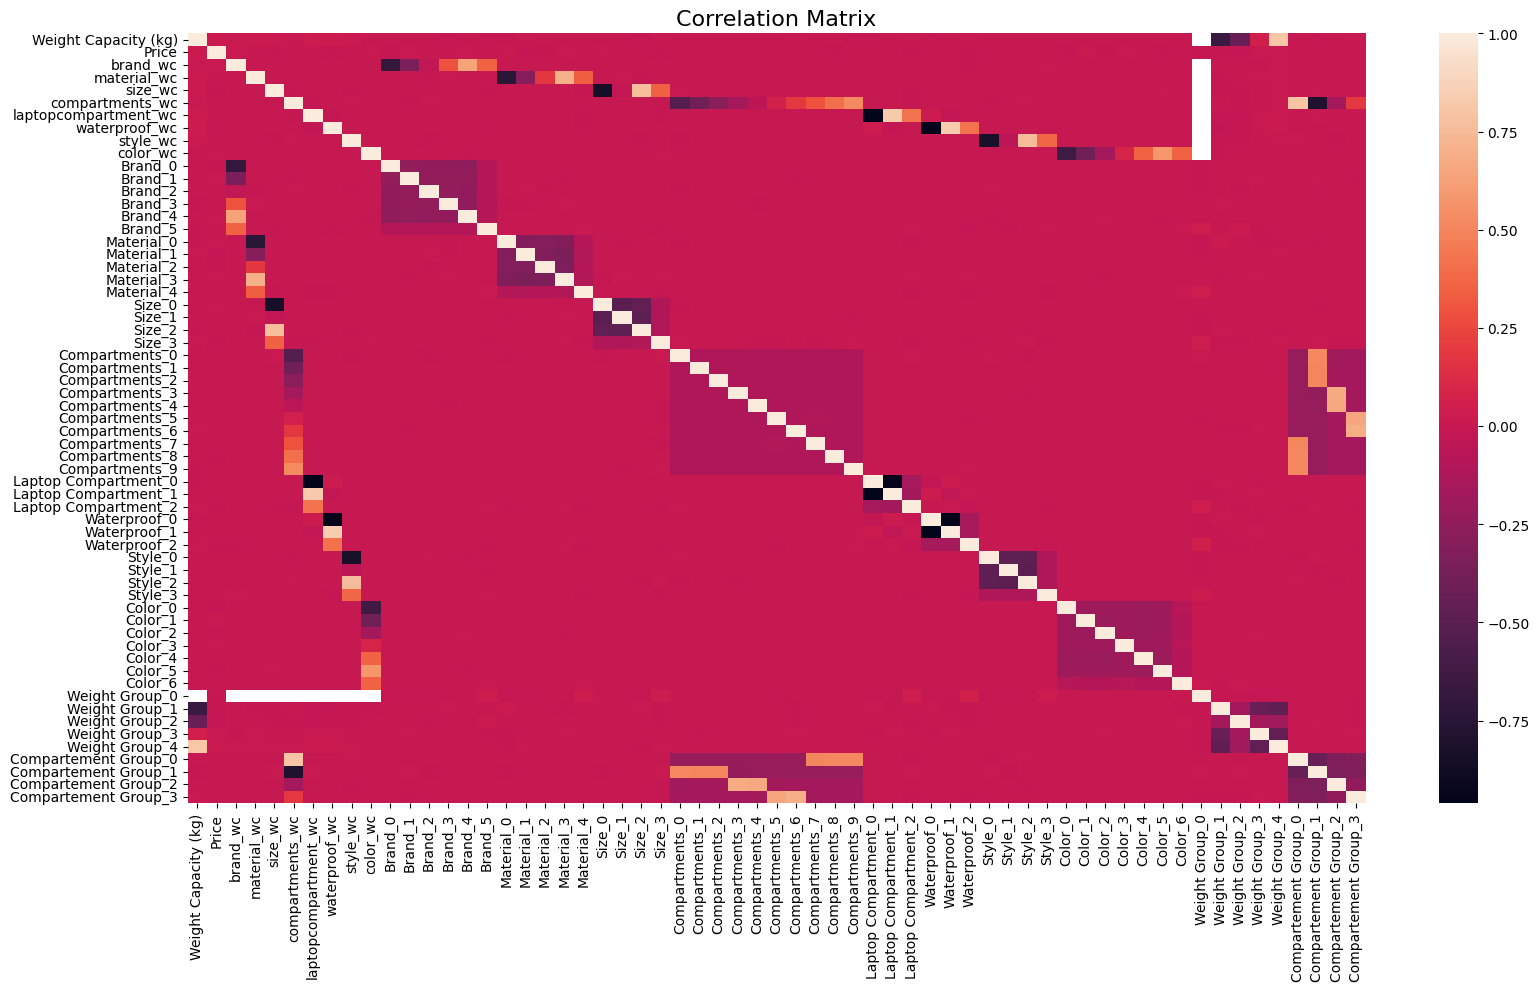

In [17]:
corr = (
    df_tot_dummy
    .select_dtypes(include=["float32", "float64", "int32", "int64"])
    .drop(columns=["id", "index"], errors='ignore')
    .corr()
)
correlation_heatmap(df_correlation=corr)

In [25]:
# Retrieving df_train & df_test
df_train_dummy = df_tot_dummy[:len(df_train)]
df_test_dummy = df_tot_dummy[len(df_train):].drop(columns=["Price"])

In [26]:
df_train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 98 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id                          int32  
 1   Weight Capacity (kg)        float32
 2   Price                       float32
 3   Weight Capacity (kg) log1   float32
 4   Weight Capacity (kg) log10  float32
 5   Weight Capacity (kg) exp    float32
 6   brand_wc                    float32
 7   material_wc                 float32
 8   size_wc                     float32
 9   compartments_wc             float32
 10  laptopcompartment_wc        float32
 11  waterproof_wc               float32
 12  style_wc                    float32
 13  color_wc                    float32
 14  weightgroup_wc              float32
 15  compartementgroup_wc        float32
 16  brandstyle_wc               float32
 17  materialcategory_wc         float32
 18  new_cat1_wc                 float32
 19  Brand_0                   

In [27]:
df_test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 97 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          200000 non-null  int32  
 1   Weight Capacity (kg)        199923 non-null  float32
 2   Weight Capacity (kg) log1   199923 non-null  float32
 3   Weight Capacity (kg) log10  199923 non-null  float32
 4   Weight Capacity (kg) exp    199923 non-null  float32
 5   brand_wc                    199923 non-null  float32
 6   material_wc                 199923 non-null  float32
 7   size_wc                     199923 non-null  float32
 8   compartments_wc             199923 non-null  float32
 9   laptopcompartment_wc        199923 non-null  float32
 10  waterproof_wc               199923 non-null  float32
 11  style_wc                    199923 non-null  float32
 12  color_wc                    199923 non-null  float32
 13  weightgroup_wc     

In [28]:
column_names = df_train_dummy.drop(columns=["Price", "index", "id"], errors="ignore").columns
X = df_train_dummy.loc[:, column_names]
y = df_train_dummy.loc[:, ["Price"]]
X_train, X_test, y_train, y_test = split_X_y_in_train_test_sets(X=X, y=y, test_size=0.1)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3594886, 96)
Test shape: (399432, 96)


In [22]:
from sklearn.linear_model import (
    Ridge,
    LinearRegression,
    Lasso,
)
from sklearn.ensemble import (
    RandomForestRegressor,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from src.model import (
    get_linear_regression_model,
    get_ridge_model,
    get_lasso_model,
    get_random_forest_model,
    get_xgboost_model,
    get_catboost_model,
    get_lgbm_model,
    run_grid_search,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import neptune


CV = 2
run = neptune.init_run(
    project=os.environ["NEPTUNE_PROJECT"],
    api_token=os.environ["NEPTUNE_KEY"],
)
best_model, parameters = get_xgboost_model()
run["algorithm"] = type(best_model).__name__
start_time = dt.datetime.now()
best_model, cv_results = run_grid_search(
    model=best_model,
    parameters=parameters,
    X_train=X_train,
    y_train=y_train.values.reshape(-1),
    number_of_split=CV,  # cv value, not too high please
)
run["model/parameters"] = str(best_model.get_params())
run["model/train_size"] = str(X_train.shape)
run["model/cross_validation"] = CV
total_time_in_minutes = round((dt.datetime.now() - start_time).seconds / 60)
run["model/run_time_minutes"] = str(total_time_in_minutes)
print(f"L'entrainement a pris {str(round(total_time_in_minutes))} minutes.")
make_a_sound(message="Entrainement du modèle terminé.")
y_test_pred = best_model.predict(X_test)
score = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
run["model/score"] = str(score)
print(f"Score: {score}.")
final_model = XGBRegressor(**best_model.get_params())
final_model.fit(X_train, y_train)
y_test_final_predict = final_model.predict(X_test)
final_score = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_final_predict))
print(f"Final score: {final_score}.")
run["model/final_score"] = str(final_score)
print("Selected params are:")
if isinstance(best_model, XGBRegressor) or isinstance(best_model, LGBMRegressor):
    print(f"LR: {best_model.get_params().get('learning_rate')}.")
    print(f"Max depth: {best_model.get_params().get('max_depth')}.")
    print(f"N estimators: {best_model.get_params().get('n_estimators')}.")
elif isinstance(best_model, CatBoostRegressor):
    print(f"depth: {best_model.get_params().get('depth')}.")
    print(f"iterations: {best_model.get_params().get('iterations')}.")
    print(f"l2_leaf_reg: {best_model.get_params().get('l2_leaf_reg')}.")
    print(f"learning_rate: {best_model.get_params().get('learning_rate')}.")
elif isinstance(best_model, Ridge) or isinstance(best_model, Lasso):
    print(f"Alpha: {best_model.get_params().get('alpha')}.")
elif isinstance(best_model, LinearRegression):
    print(f"Intercept: {best_model.get_params().get('fit_intercept')}.")
elif isinstance(best_model, RandomForestRegressor):
    print(f"n_estimators: {best_model.get_params().get('n_estimators')}.")
    print(f"max_depth: {best_model.get_params().get('max_depth')}.")
elif isinstance(best_model, KNeighborsRegressor):
    print(f"n_neighbors: {best_model.get_params().get('n_neighbors')}.")
    print(f"weights: {best_model.get_params().get('weights')}.")
else:
    raise TypeError(f"{type(best_model)}")
print(f"Score: {score:.2f}")
ref_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=np.ones(len(y_test))*ref_price))
print(f"Ref score is {ref_rmse}.")
print(f"Improvement of {(ref_rmse - score) * 100:.2f}% comparing to reference one.")
run.stop()

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/picx/kaggle-swag-competition/e/KAG-43
Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=-38.938 total time=   3.6s
[CV 2/2] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=-38.932 total time=   3.3s
[CV 1/2] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-38.931 total time=   4.7s
[CV 2/2] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-38.924 total time=   4.7s
[CV 1/2] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=-38.926 total time=   5.8s
[CV 2/2] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=-38.919 total time=   6.0s
[CV 1/2] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-38.922 total time=   8.6s
[CV 2/2] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-38.915 total time=   7.4s
[CV 1/2] END learning_rate=0.01, max_d

InvalidParameterError: The 'y_pred' parameter of mean_squared_error must be an array-like. Got 107245537.01877594 instead.

In [40]:
from xgboost import XGBRegressor
final_model2 = XGBRegressor(
    max_depth=10,
    colsample_bytree=0.5,
    subsample=0.8,
    n_estimators=15_000,
    learning_rate=0.01,
    enable_categorical=True,
    min_child_weight=10,
    early_stopping_rounds=100,
)

final_model2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=300,
)

[0]	validation_0-rmse:38.93297
[300]	validation_0-rmse:38.87039
[600]	validation_0-rmse:38.86553
[900]	validation_0-rmse:38.86513
[940]	validation_0-rmse:38.86537


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=11, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=15000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

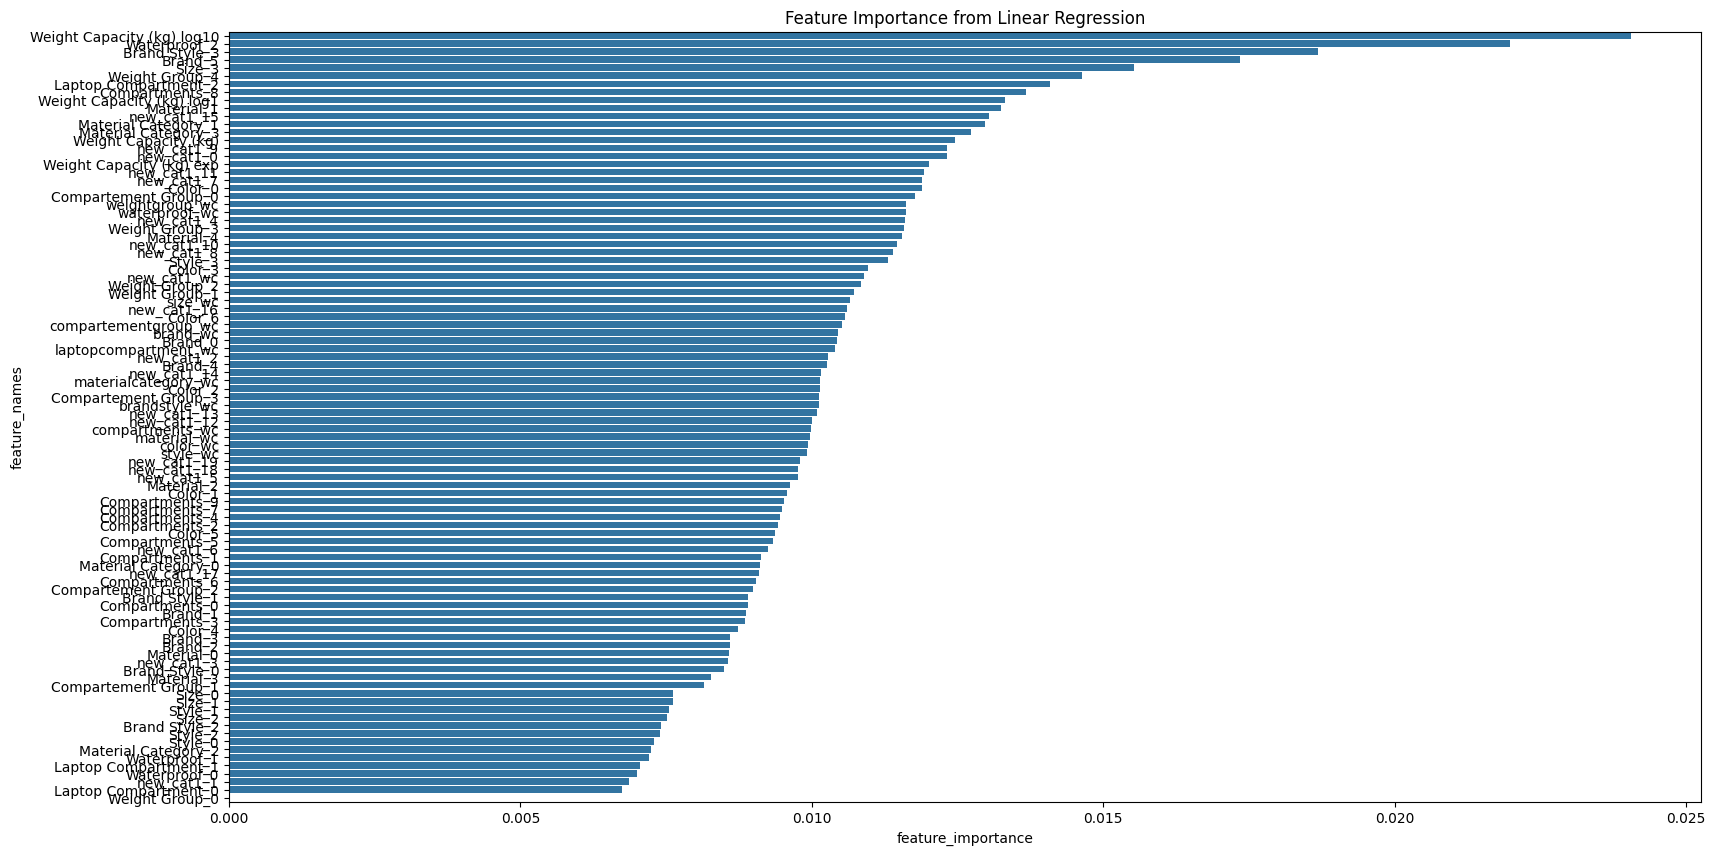

In [41]:
vizualize_feature_importance(
    model=final_model2,
    feature_names=column_names,
)

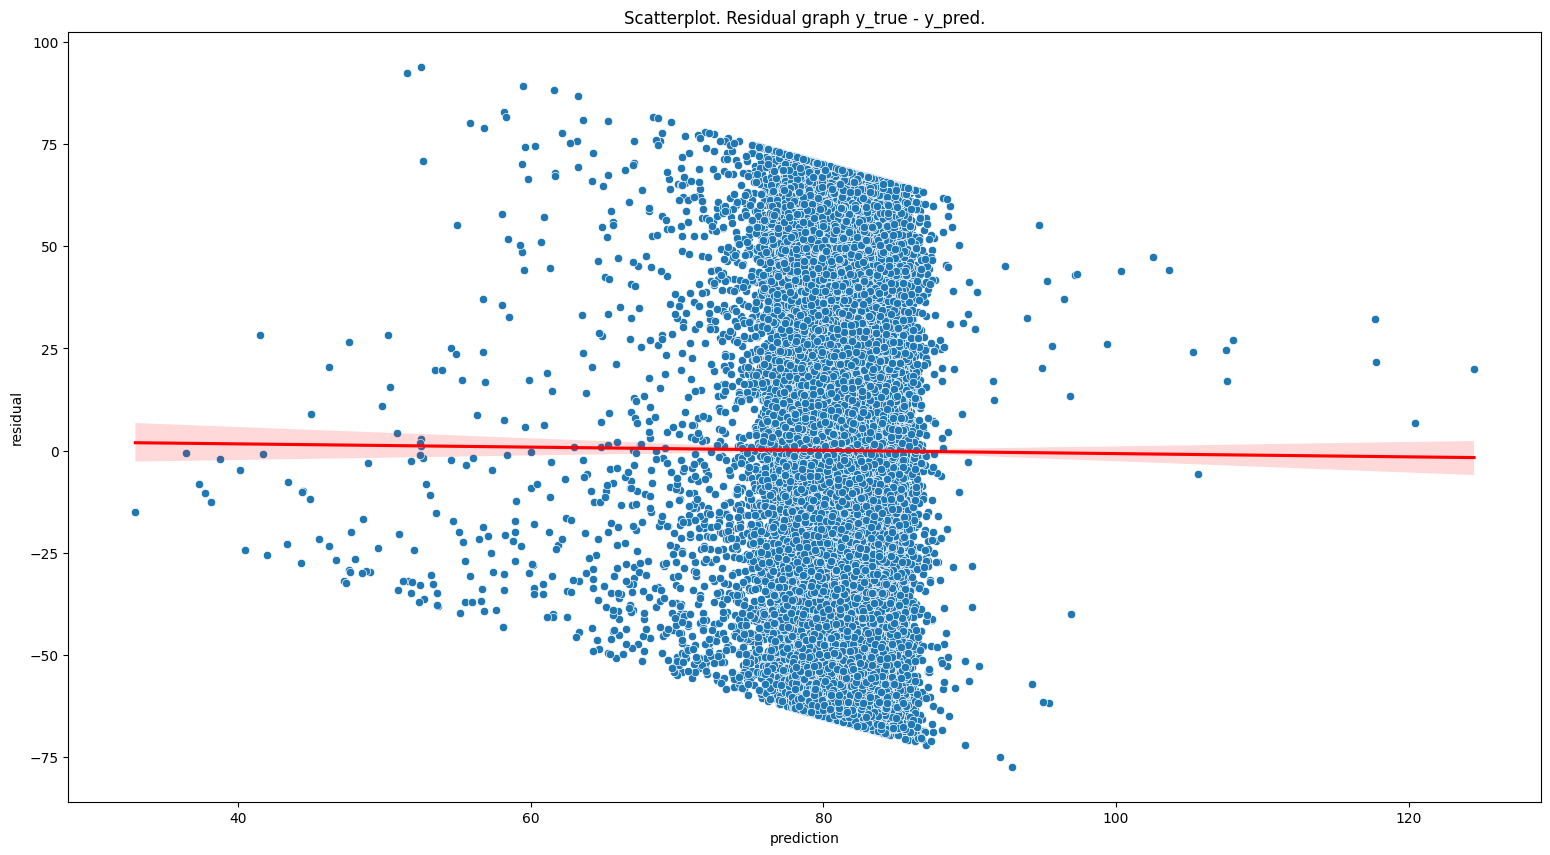

In [42]:
vizualise_residual(
    y_true=y_test["Price"].values,
    y_pred=final_model2.predict(X_test[column_names]).reshape(-1),
    subset=100_000,
)

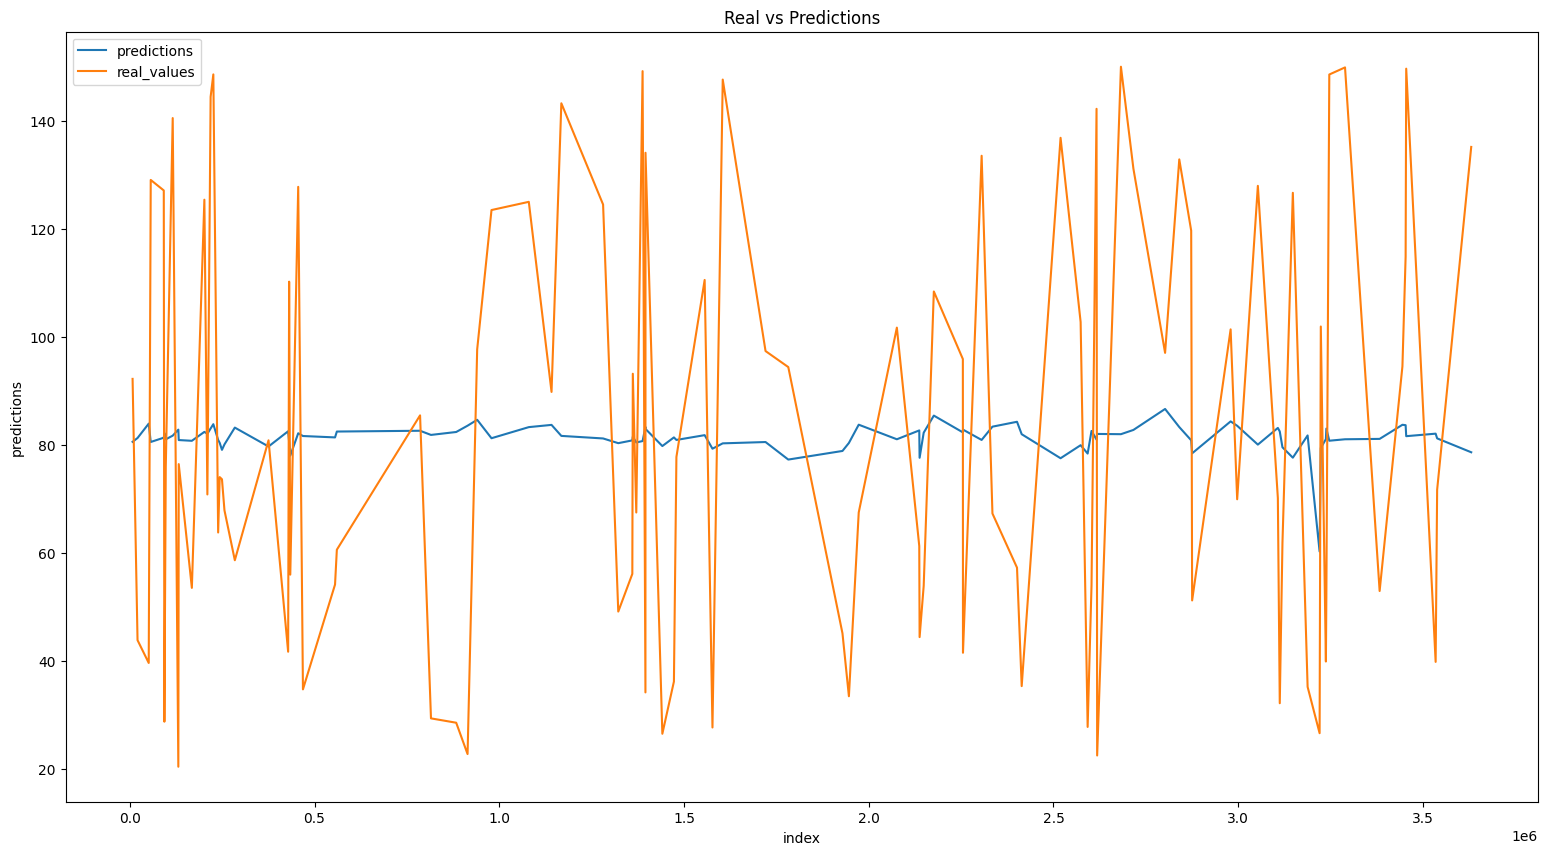

In [43]:
X_test["predictions"] = final_model2.predict(X_test[column_names]).reshape(-1)
X_test["real_values"] = y_test.loc[:, ["Price"]]

compare_predictions_and_real_values(
    df=X_test.reset_index().iloc[:100]
)

In [44]:
df_test_dummy["Price_prediction"] = final_model2.predict(df_test_dummy.loc[:, column_names])
df_test_dummy

,id,Weight Capacity (kg),Weight Capacity (kg) log1,Weight Capacity (kg) log10,Weight Capacity (kg) exp,brand_wc,material_wc,size_wc,compartments_wc,laptopcompartment_wc,...,new_cat1_11,new_cat1_12,new_cat1_13,new_cat1_14,new_cat1_15,new_cat1_16,new_cat1_17,new_cat1_18,new_cat1_19,Price_prediction
0,300000,0.381647,0.502022,0.506374,-0.291145,300.381653,100.381645,200.381653,100.381645,0.381647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.384796
1,300001,-0.637448,-0.444778,-0.426395,-0.291802,199.362549,-0.637448,99.362549,599.362549,-0.637448,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,82.974258
2,300002,-0.889001,-0.750553,-0.733022,-0.291802,-0.889001,-0.889001,-0.889001,799.111023,-0.889001,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.261299
3,300003,0.067028,0.247716,0.257944,-0.291729,0.067028,200.067032,0.067028,0.067028,100.067032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.758415
4,300004,-1.161711,-1.133441,-1.121776,-0.291802,498.838287,198.838287,-1.161711,98.838287,98.838287,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,78.696030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,-1.523699,-1.760541,-1.772880,-0.291802,-1.523699,-1.523699,-1.523699,98.476303,98.476303,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80.690460
199996,499996,-1.713708,-2.170421,-2.210807,-0.291802,198.286285,298.286285,198.286285,798.286316,-1.713708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.482140
199997,499997,1.273405,1.103073,1.088693,0.038431,101.273407,201.273407,201.273407,801.273376,1.273405,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,82.744637
199998,499998,1.112661,1.005339,0.994417,-0.184162,301.112671,201.112656,1.112661,901.112671,101.112663,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,81.793724


<Figure size 1900x1000 with 0 Axes>

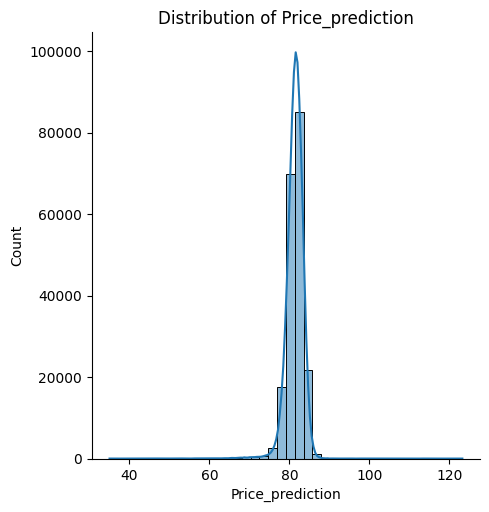

In [45]:
# distplot(df=df_test_filled_n, variable_name="log_Price_prediction")
distplot(df=df_test_dummy, variable_name="Price_prediction")

In [46]:
# df_test_dummy["Price_prediction"] = df_test_dummy["Price_prediction"].mean()
prepare_submission(df_predictions=df_test_dummy.rename(columns={"Price_prediction": "prediction"}))

Generating output: data/my_submission.csv.


In [47]:
submit_file(message="On tente des trucs v2.")
make_a_sound(message="Submission envoyé à Kaggle.")

Submitting data/my_submission.csv to competition:playground-series-s5e2


100%|██████████| 2.48M/2.48M [00:01<00:00, 1.39MB/s]


In [49]:
get_submission_scores()

Retrieving scores from competition:playground-series-s5e2
43083685 - 39.10124 -  - 2025-02-24 21:38:31
43083518 - 39.09848 -  - 2025-02-24 21:29:07
43083275 - 39.10193 -  - 2025-02-24 21:10:50
43082272 - 39.09970 -  - 2025-02-24 19:44:10
43082105 - 39.18728 -  - 2025-02-24 19:27:55
43061578 - 39.18728 -  - 2025-02-23 18:43:52
